### Định nghĩa các hàm sử dụng

In [ ]:
import os
import cv2
import math
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as MDA
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
# 1. Preprocess silhouettes (đã test xong) chạy oke
# chuyển ảnh silhoute thành ảnh nhị phân trắng đen
def preprocess_silhouettes(folder_path):
    silhouettes = []
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_paths:
        raise ValueError("No valid image files found in the folder.")
    
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"⚠️ Warning: Cannot read image at {path}")
            break
        
        _, binary = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)
        silhouettes.append(binary)
        
    if not silhouettes:
        raise ValueError("No Valid images were processed. Check file paths")
    
    return np.array(silhouettes)

# 2. Compute Gait Energy Image (GEI) (chạy oke)
# sử dụng ảnh silhoute trắng đen trước đó để tính ảnh GEI
def compute_gei(silhouettes):
    return np.mean(silhouettes, axis=0)

def show_image(image, title="Image", scale=7):
    h, w = image.shape
    resized_image = cv2.resize(image, (w * scale, h * scale), interpolation=cv2.INTER_NEAREST)
    cv2.imshow(title, resized_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
# lưu ảnh vào thư mục đã chọn
def save_image(image, folder_path, image_name):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    save_path = os.path.join(folder_path, image_name)
    cv2.imwrite(save_path, image)
    # print(f"✅ Image saved at {save_path}")

root_folder = "data"
gei_path = "GEI"

def gei_img_process(root_folder):
    labels = []
    for object in os.listdir(root_folder):
        if not os.path.exists(f"{gei_path}/{object}"):
            os.makedirs(f"{gei_path}/{object}")
        for folder in os.listdir(f"{root_folder}/{object}"):
            a = 0
            if not os.path.exists(f"{gei_path}/{object}/{folder}"):
                os.makedirs(f"{gei_path}/{object}/{folder}")
            for direction in os.listdir(f"{root_folder}/{object}/{folder}"):
                # binary_imgs = preprocess_silhouettes(f"{root_folder}/{object}/{folder}/{direction}")
                # gei = compute_gei(binary_imgs)
                # save_image((gei*255).astype(np.uint8),f"{gei_path}/{object}/{folder}", f"{direction}.jpg")
                a += 1
        labels.append(a)
    print(labels)
    return labels

def load_data(folder_paths):
    gallery, probe = [], []
    prob = ["bg-01", "bg-02", "cl-01", "cl-02", "nm-01", "nm-02"]
    for object in os.listdir(folder_paths):
        for type in os.listdir(f"{folder_paths}/{object}"):
            for dir in os.listdir(f"{folder_paths}/{object}/{type}"):
                img = cv2.imread(f"{folder_paths}/{object}/{type}/{dir}", cv2.IMREAD_GRAYSCALE)
                if(type in prob):
                    probe.append(img)
                else:
                    gallery.append(img)
    
    return gallery, probe

def synthetic_templates(real_imgs, iter = 4, k = 2):
    x, y = real_imgs[0].shape
    synthetic_templates = []
    h = 2, max(x, y)
    
    for img in real_imgs:
        for i in range(1,1+iter):
            temp = np.copy(img)
            # remove k*i rows from the bottoms of the original img
            cut_bot = temp[0:x-i*k, 0:y]
            d = math.floor(x*y/(x-i*k))
            # resize the remaining template
            cut_bot = cv2.resize(cut_bot, (d, x))
            # equally cut left and right borders to generate a x*y size synthetic template
            cut_bot = cut_bot[:,i:d-i]
            
            cut_top = temp[i*k:x, 0:y]
            cut_top = cv2.resize(cut_top, (d, x))
            cut_top = cut_top[:,i:d-i]
            if cut_bot.shape[1] == 65: 
                cut_bot = cut_bot[:,1:65]
            if cut_top.shape[1] == 65:
                cut_top = cut_top[:, 1:65]
                
            synthetic_templates.append(cut_bot)
            synthetic_templates.append(cut_top)
    
    return synthetic_templates

# tạo labels để đưa vào hàm MDA
def create_labels(gallery_imgs_per_object, probe_imgs_per_object, labels_token):
    real_labels, probe_labels = [], []
    gallery_size, probe_size = gallery_imgs_per_object ,probe_imgs_per_object
      
    for i, object in enumerate(labels_token):
        for _ in range(object*gallery_size):
            real_labels.append(i+1)
        
    for i, object in enumerate(labels_token):
        for _ in range(object*probe_size):
            probe_labels.append(i+1)
        
    print(len(real_labels))
    print(len(probe_labels))
    return real_labels, probe_labels

def pca_and_mda(real, synthetic, real_labels, synthetic_labels):
    real_in,  synth_in = [], []
    for r in real:
        real_in.append(r.flatten())
    for s in synthetic:
        synth_in.append(s.flatten())  
    # calculate PCA    
    pca = PCA(n_components=100)
    real_pca = pca.fit_transform(real_in)
    
    # calculate MDA
    mda = MDA(n_components= 19)
    real_mda = mda.fit_transform(real_pca, real_labels)
    
     
    # calculate PCA    
    pca = PCA(n_components=100)
    synthetic_pca = pca.fit_transform(synth_in)
    
    # calculate MDA
    mda = MDA(n_components=19)
    synthetic_mda = mda.fit_transform(synthetic_pca, synthetic_labels)
    
    return real_pca, real_mda, synthetic_pca, synthetic_mda

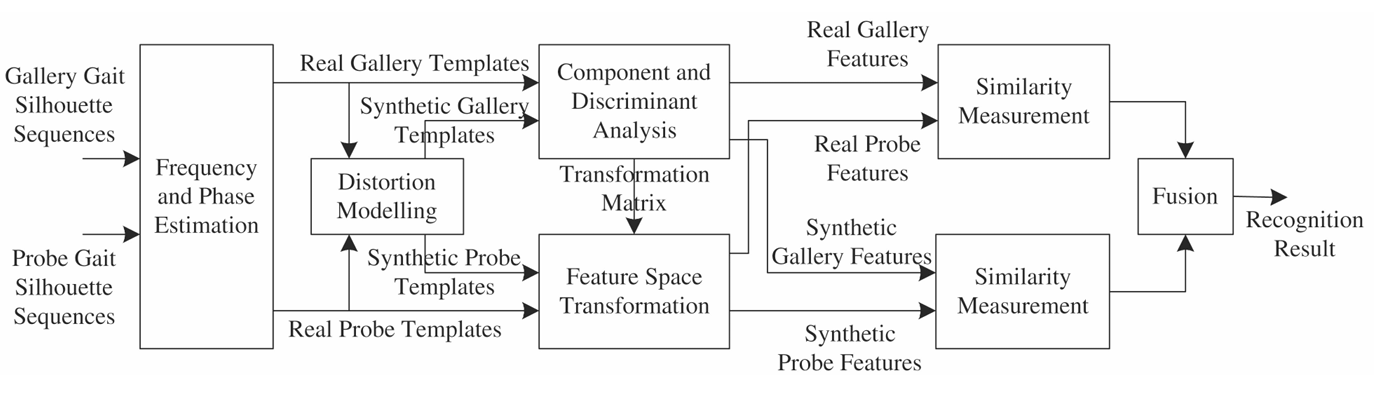

# Tiền xử lý dữ liệu

In [6]:

# Main
root_path = "data"
gei_path = "GEI"

if not os.path.exists(gei_path):
    os.makedirs(gei_path)  

# xử lý ảnh GEI và lưu lại về và trả về token labels cho mỗi đối tượng trong dataset
# xóa comment phần xử lý ảnh trong hàm gei_img_process nếu chưa có dữ liệu ảnh GEI hoặc thêm/bớt dữ liệu
token = gei_img_process(root_folder)

# tải data lên lại để xử lý
view = "000"
real_gallery, real_probe = load_data(gei_path, f"{view}.jpg")

print(len(real_gallery), len(real_probe))
# tạo thêm ảnh synthetic cho gallery và probe
synthetic_gallery = synthetic_templates(real_gallery)
synthetic_probe = synthetic_templates(real_probe)

# tạo labels để sử dụng trong hàm MDA
real_gallery_labels, real_probe_labels = create_labels(4, 6, token)
syn_gallery_labels, syn_probe_labels = create_labels(32, 48, token)

# hết cả đoạn code trên chạy tốn khoảng 1 giây, khi ko cần xử lý ảnh GEI trong gei_img_process :>

[11, 11, 11, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
Loading data completed!
190 0


IndexError: list index out of range

In [ ]:
def pca_transform(data, n_components):
    for i in range(len(data)):
        data[i] = data[i].flatten()
        
    mean = np.mean(data)
    centered_data = data - mean
    covariance_matrix = np.cov(centered_data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::1]
    eigenvectors = eigenvectors[:,sorted_indices[:n_components]]
    transformed_data = np.dot(centered_data, eigenvectors)
    return eigenvalues, eigenvectors, mean, transformed_data

''' trả về giá trị mean để sử dụng như đầu vào Transform matrix để thực hiện
chuẩn hóa tập dữ liệu synthetic theo tâp dữ thựcthực'''

# Khối số 4 : Feature space transformation
def pca_feature_transfrom(data, mean, n_components):
    for i in range(len(data)):
        data[i] = data[i].flatten()
        
    centered_data = data - mean
    covariance_matrix = np.cov(centered_data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::1]
    eigenvectors = eigenvectors[:,sorted_indices[:n_components]]
    transformed_data = np.dot(centered_data, eigenvectors)
    return eigenvalues, eigenvectors, transformed_data

In [ ]:
# Khối số 3 : Component and Discriminant analysis
# TRÍCH XUẤT ĐẶC TRƯNG
c = 20 # số đối tượng nhận diện trong tâp dữ liệu
n_comp = 2 * c
mda_comp = c - 1

# real_gallery --> pca --> real_mean --> pca_transform(real_probe) --> rp_transformed --> mda --> rp_feature
#                   \--> rg_transformed --> mda --> rg_feature


In [5]:
# this may take around 1 minute to run
rg_values , rg_vectors, real_mean, rg_transformed = pca_transform(real_gallery, n_comp) # 1 
_, _, rp_transformed = pca_feature_transfrom(real_probe, real_mean, n_comp) # 3

In [6]:
# this may take around 1 minute to run
sg_values, sg_vectors, syn_mean, sg_transformed = pca_transform(synthetic_gallery, n_comp) # 2
_, _, sp_transforemd= pca_feature_transfrom(synthetic_probe, syn_mean, n_comp) # 4

In [7]:
mda = MDA(n_components=mda_comp)
rg_feature = mda.fit_transform(rg_transformed, real_gallery_labels) # 1
sg_feature = mda.fit_transform(sg_transformed, syn_gallery_labels) # 2
rp_feature = mda.fit_transform(rp_transformed, real_probe_labels) # 3
sp_feature = mda.fit_transform(sp_transforemd, syn_probe_labels) # 4

rg_feature.shape, sg_feature.shape, rp_feature.shape, sp_feature.shape

((876, 19), (7008, 19), (1314, 19), (10512, 19))

In [8]:
real_sim = cosine_similarity(rg_feature, rp_feature)
synthetic_sim = cosine_similarity(sg_feature, sp_feature)

real_sim.shape, synthetic_sim.shape

((876, 1314), (7008, 10512))

In [30]:
# index of first occurrence of each value
real_pred = []

for i in range(len(real_sim)):
    real_pred.append(max(real_sim[i]))
    
# print(len(real_pred))
real_pred_labels = []
for i in range(len(real_sim)):
    temp = (np.where(real_sim[i]==real_pred[i]))
    real_pred_labels.append(temp[0][0])

accuracy = 0.0
for i in range(len(real_pred_labels)):
    if real_probe_labels[real_pred_labels[i]] == real_probe_labels[i]:
        accuracy += 1
    
accuracy = (accuracy / float(len(real_probe_labels)))*100
print( "Độ chính xác: ", accuracy,"%")

Độ chính xác:  3.881278538812785 %


In [ ]:
# print(synthetic_sim.shape)
m# len(synthetic_pred)
len(real_pred)
print(real_pred[0])

0.6454086000495761


In [19]:
# index of first occurrence of each value
synthetic_pred = []

for i in range(len(synthetic_sim)):
    real_pred.append(max(synthetic_sim[i]))

print(len(real_pred))
synthetic_pred_labels = []
for i in range(len(synthetic_sim)):
    temp = (np.where(synthetic_sim[i]==synthetic_pred[i]))
    synthetic_pred_labels.append(temp[0][0])

accuracy = 0.0
for i in range(len(synthetic_pred_labels)):
    if syn_probe_labels[synthetic_pred_labels[i]] == syn_probe_labels[i]:
        accuracy += 1
    
accuracy = (accuracy / float(len(syn_probe_labels)))*100
print( "Độ chính xác: ", accuracy,"%")

21900


IndexError: list index out of range